사전학습된 한국어 BERT(klue/bert-base) 모델을 사용하지만

BERT 본체(encoder)는 모두 동결(freeze)하고, 분류기 헤드(classifier)만 학습

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    AdamW
)
from torch.utils.data import Dataset, DataLoader
import random

# 하이퍼파라미터
MAX_LEN = 128
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-6
EPOCHS = 5
MODEL_NAME = "klue/roberta-base"
N_FOLDS = 5
RANDOM_SEED = 42
AUGMENT_K = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(RANDOM_SEED)

# 데이터 로드
print("데이터 로드 중...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
if 'text' in test_df.columns:
    test_df = test_df.rename(columns={'text': 'conversation'})
if 'file_name' in test_df.columns:
    test_df = test_df.rename(columns={'file_name': 'idx'})

# 텍스트 전처리
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text).strip())
    return text
train_df['conversation'] = train_df['conversation'].apply(clean_text)
test_df['conversation'] = test_df['conversation'].apply(clean_text)

# 클래스 표준화 및 매핑
custom_classes = ['협박', '갈취', '직장내괴롭힘', '기타괴롭힘', '일반']
class2idx = {
    '협박': 0, '협박 대화': 0,
    '갈취': 1, '갈취 대화': 1,
    '직장내괴롭힘': 2, '직장 내 괴롭힘 대화': 2,
    '기타괴롭힘': 3, '기타 괴롭힘 대화': 3,
    '일반': 4, '일반대화': 4
}
def extract_class(x):
    if '협박' in x:
        return '협박'
    elif '갈취' in x:
        return '갈취'
    elif '직장' in x:
        return '직장내괴롭힘'
    elif '기타' in x:
        return '기타괴롭힘'
    elif '일반' in x:
        return '일반'
    return x
train_df['class'] = train_df['class'].apply(extract_class)
train_df['target'] = train_df['class'].map(class2idx)
assert train_df['target'].isna().sum() == 0, "클래스 매핑 오류 발생!"

idx2class = {i: c for i, c in enumerate(custom_classes)}

# 토크나이저
print(f"토크나이저 로드 중: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 데이터 증강 함수
def augment_data(texts, labels, k=AUGMENT_K):
    augmented_texts = []
    augmented_labels = []
    for text, label in zip(texts, labels):
        augmented_texts.append(text)
        augmented_labels.append(label)
        if k > 0:
            sentences = text.split('. ')
            if len(sentences) > 1:
                shuffled = '. '.join(sentences[::-1])
                augmented_texts.append(shuffled)
                augmented_labels.append(label)
            if len(sentences) > 2:
                del_idx = random.randint(0, len(sentences)-1)
                new_text = '. '.join(sentences[:del_idx] + sentences[del_idx+1:])
                augmented_texts.append(new_text)
                augmented_labels.append(label)
            words = text.split()
            if len(words) > 5:
                for _ in range(min(k-2, 1)):
                    mod_text = text
                    if '은' in mod_text:
                        mod_text = mod_text.replace('은', '는', 1)
                    elif '는' in mod_text:
                        mod_text = mod_text.replace('는', '은', 1)
                    elif '이' in mod_text:
                        mod_text = mod_text.replace('이', '가', 1)
                    elif '가' in mod_text:
                        mod_text = mod_text.replace('가', '이', 1)
                    if mod_text != text:
                        augmented_texts.append(mod_text)
                        augmented_labels.append(label)
    return augmented_texts, augmented_labels

# 일반대화 합성 데이터 예시
def create_normal_conversations(n=1000):
    print("일반 대화 데이터 생성 중...")
    normal_conversations = [
        "이거 들어봐 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 옴 난 좀 별로네 아님 넌 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래"
    ]
    return normal_conversations * (n // len(normal_conversations))

normal_convs = create_normal_conversations()
normal_df = pd.DataFrame({
    'class': ['일반'] * len(normal_convs),
    'conversation': normal_convs,
    'target': [4] * len(normal_convs)
})
train_df = pd.concat([train_df, normal_df], ignore_index=True)

# PyTorch Dataset
class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 교차 검증
print(f"{N_FOLDS}개 폴드 교차 검증 시작...")
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
test_predictions_folds = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['conversation'], train_df['target'])):
    print(f"\n===== 폴드 {fold+1}/{N_FOLDS} 학습 시작 =====")
    X_train = train_df['conversation'].iloc[train_idx].tolist()
    y_train = train_df['target'].iloc[train_idx].values
    X_val = train_df['conversation'].iloc[val_idx].tolist()
    y_val = train_df['target'].iloc[val_idx].values

    # 데이터 증강
    print("데이터 증강 적용 중...")
    augmented_texts, augmented_labels = augment_data(X_train, y_train)
    print(f"증강 전: {len(X_train)}개, 증강 후: {len(augmented_texts)}개")
    train_dataset = ConversationDataset(augmented_texts, augmented_labels, tokenizer, MAX_LEN)
    val_dataset = ConversationDataset(X_val, y_val, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 모델 로드
    print(f"모델 로드 중: {MODEL_NAME}")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(custom_classes)
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = torch.nn.CrossEntropyLoss()

    # 학습
    print(f"모델 학습 중...")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

    # 검증 세트 예측
    print("검증 세트 평가 중...")
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print(f"검증 F1 점수: {val_f1:.4f}")

    # 테스트 세트 예측
    print("테스트 세트 예측 중...")
    test_texts = test_df['conversation'].tolist()
    test_dataset = ConversationDataset(test_texts, labels=None, tokenizer=tokenizer, max_len=MAX_LEN)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_preds = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
    test_predictions_folds.append(test_preds)
    fold_metrics.append({'fold': fold + 1, 'val_f1': val_f1})

    del model
    torch.cuda.empty_cache()

# 앙상블 (hard voting)
test_predictions = np.zeros((len(test_df),), dtype=int)
test_pred_array = np.array(test_predictions_folds)
for i in range(len(test_df)):
    test_predictions[i] = np.bincount(test_pred_array[:, i]).argmax()

# 예측 분포 확인
pred_dist = {idx2class[i]: np.sum(test_predictions == i) for i in range(len(custom_classes))}
print("\n예측 클래스 분포:")
for cls, count in pred_dist.items():
    print(f"{cls}: {count} ({count/len(test_predictions)*100:.2f}%)")

# 결과 저장
submission = pd.DataFrame({
    'idx': test_df['idx'],
    'target': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("\n제출 파일 생성 완료: submission.csv")

mean_f1 = np.mean([m['val_f1'] for m in fold_metrics])
print(f"\n교차검증 평균 F1 점수: {mean_f1:.4f}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(classification_report(y_val, val_preds, target_names=custom_classes))

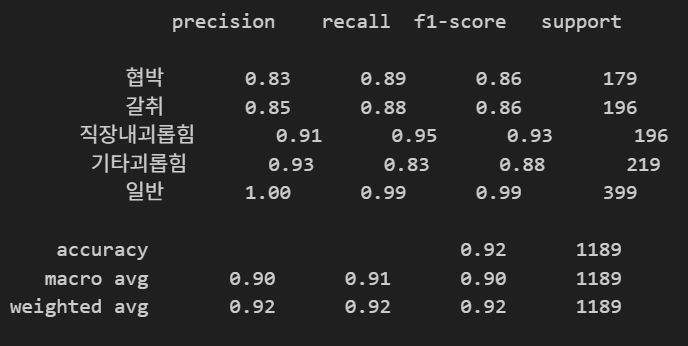

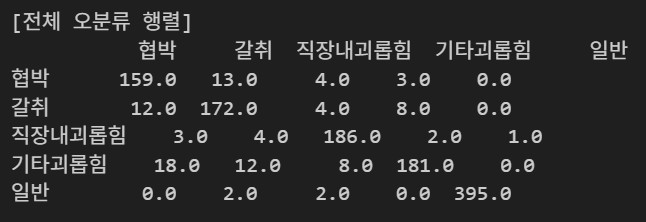

In [ ]:
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=custom_classes, yticklabels=custom_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

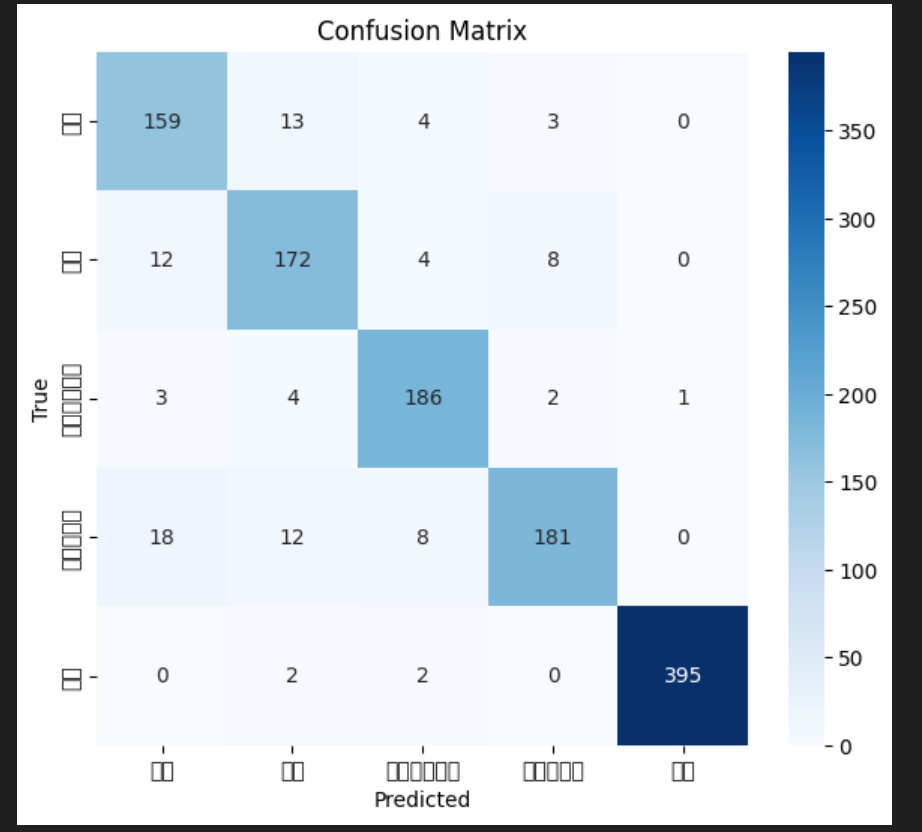

In [ ]:
for i, (true, pred) in enumerate(zip(y_val, val_preds)):
    if true != pred:
        print(f"실제: {idx2class[true]}, 예측: {idx2class[pred]}, 텍스트: {X_val[i]}")

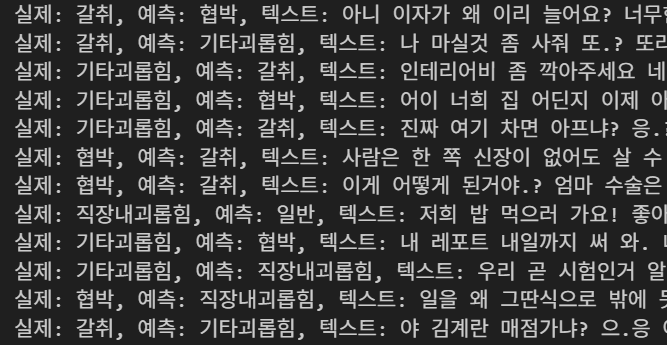

In [ ]:
# 상위 N개 오분류 유형 자동 추출
error_pairs = []
for (true, pred), count in np.ndenumerate(error_matrix):
    if true != pred:
        error_pairs.append((error_matrix.index[true], error_matrix.columns[pred], count))

top_errors = sorted(error_pairs, key=lambda x: x[2], reverse=True)[:5]  # 상위 5개

print("\n[상위 오분류 유형]")
for true, pred, count in top_errors:
    print(f"{true} → {pred}: {count}건")


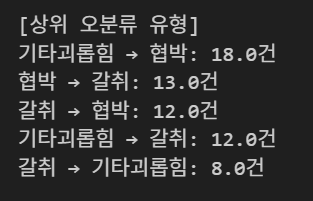